## 1. Introduction to Baby Names Data
<blockquote>
  <p>What’s in a name? That which we call a rose, By any other name would smell as sweet.</p>
</blockquote>
<p>In this project, we will explore a rich dataset of first names of babies born in the US, that spans a period of more than 100 years! This suprisingly simple dataset can help us uncover so many interesting stories, and that is exactly what we are going to be doing. </p>
<p>Let us start by reading the data.</p>

In [2]:
import pandas as pd

# Read names into a dataframe: bnames
bnames = pd.read_csv("datasets/names.csv.gz")
bnames.head(5)

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


## 2. Exploring Trends in Names
<p>One of the first things we want to do is to understand naming trends. Let us start by figuring out the top five most popular male and female names for this decade (born 2011 and later). Do you want to make any guesses? Go on, be a sport!!</p>

In [62]:
# bnames_top5: A dataframe with top 5 popular male and female names for the decade
bnames_2011 = bnames[bnames['year'] > 2010]
agg = bnames_2011.groupby(['name','sex'], as_index = False)['births'].sum()
bnames_top = agg.sort_values(['sex','births'], ascending = [True, False])
top_5_F = bnames_top.head(5)
top_5_F

top_5_M = bnames_top[bnames_top.sex == 'M'].head()
top_5_M

,name,sex,births
38198,Noah,M,110280
34416,Mason,M,105104
20874,Jacob,M,104722
31398,Liam,M,103250
49601,William,M,99144


## 3. Proportion of Births
<p>While the number of births is a useful metric, making comparisons across years becomes difficult, as one would have to control for population effects. One way around this is to normalize the number of births by the total number of births in that year.</p>

In [6]:
bnames2 = bnames.copy()
# Compute the proportion of births by year and add it as a new column

bnames['birth_sum'] = bnames.groupby('year', as_index = False)['births'].\
transform(lambda x: x.sum())

bnames['prop_births'] = bnames['births']/bnames['birth_sum']
bnames.head()

,name,sex,births,year,birth_sum,prop_births
0,Mary,F,7065,1880,201483,0.035065
1,Anna,F,2604,1880,201483,0.012924
2,Emma,F,2003,1880,201483,0.009941
3,Elizabeth,F,1939,1880,201483,0.009624
4,Minnie,F,1746,1880,201483,0.008666


## 4. Popularity of Names
<p>Now that we have the proportion of births, let us plot the popularity of a name through the years. How about plotting the popularity of the female names <code>Elizabeth</code>, and <code>Deneen</code>, and inspecting the underlying trends for any interesting patterns!</p>

In [8]:
from scipy.signal import find_peaks_cwt
import numpy as np

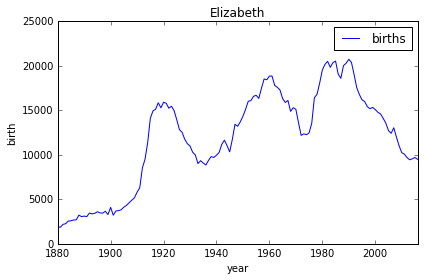

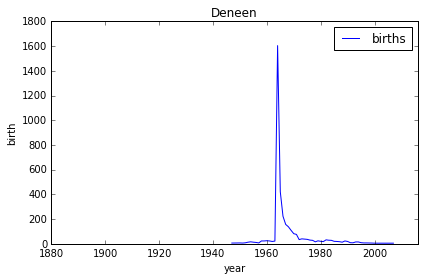

In [9]:
# Set up matplotlib for plotting in the notebook.
%matplotlib inline
import matplotlib.pyplot as plt

def plot_trends(name, sex): 
    data = bnames[(bnames['name']==name)&(bnames['sex']==sex)]
    ax = data.plot(x='year', y='births')
    ax.set_xlim(1880,2016)
    plt.title(name)
    plt.ylabel('birth')
    return ax

# Plot trends for Elizabeth and Deneen 
names = ['Elizabeth','Deneen']
for name in names:
    plot_trends(name,'F')
    
# How many times did these female names peak?
num_peaks_elizabeth = len(find_peaks_cwt(np.array(bnames[
 (bnames.name == 'Elizabeth') & (bnames.sex == 'F')]['births']), 
                                         np.arange(1, 40)))

num_peaks_deneen = len(find_peaks_cwt(np.array(bnames[
(bnames.name == 'Deneen')&(bnames.sex == 'F')]['births']),np.arange(1,70)))


## 5. Trendy vs. Stable Names
<p>Based on the plots we created earlier, we can see that <strong>Elizabeth</strong> is a fairly stable name, while <strong>Deneen</strong> is not. An interesting question to ask would be what are the top 5 stable and top 5 trendiest names. A stable name is one whose proportion across years does not vary drastically, while a trendy name is one whose popularity peaks for a short period and then dies down. </p>
<p>There are many ways to measure trendiness. A simple measure would be to look at the maximum proportion of births for a name, normalized by the sume of proportion of births across years. For example, if the name <code>Joe</code> had the proportions <code>0.1, 0.2, 0.1, 0.1</code>, then the trendiness measure would be <code>0.2/(0.1 + 0.2 + 0.1 + 0.1)</code> which equals <code>0.5</code>.</p>
<p>Let us use this idea to figure out the top 10 trendy names in this data set, with at least a 1000 births.</p>

In [11]:
# top10_trendy_names | A Data Frame of the top 10 most trendy names
names=pd.DataFrame()

name_and_sex_grouped = bnames.groupby(['name','sex'])

names['total']=name_and_sex_grouped['births'].sum()
names['max']=name_and_sex_grouped['births'].max()
names['trendiness'] = names['max']/names['total']

top10_trendy_names = names[names.total >= 1000].sort_values(
    by='trendiness', ascending = False).head(10).reset_index()

top10_trendy_names

,name,sex,total,max,trendiness
0,Christop,M,1082,1082,1.000000
1,Royalty,F,1057,581,0.549669
2,Kizzy,F,2325,1116,0.480000
3,Aitana,F,1203,564,0.468828
4,Deneen,F,3602,1604,0.445308
5,Moesha,F,1067,426,0.399250
6,Marely,F,2527,1004,0.397309
7,Kanye,M,1304,507,0.388804
8,Tennille,F,2172,769,0.354052
9,Kadijah,F,1411,486,0.344437


## 6. Bring in Mortality Data
<p>So, what more is in a name? Well, with some further work, it is possible to predict the age of a person based on the name (Whoa! Really????). For this, we will need actuarial data that can tell us the chances that someone is still alive, based on when they were born. Fortunately, the <a href="https://www.ssa.gov/">SSA</a> provides detailed <a href="https://www.ssa.gov/oact/STATS/table4c6.html">actuarial life tables</a> by birth cohorts.</p>
<table>
<thead>
<tr>
<th style="text-align:right;">year</th>
<th style="text-align:right;">age</th>
<th style="text-align:right;">qx</th>
<th style="text-align:right;">lx</th>
<th style="text-align:right;">dx</th>
<th style="text-align:right;">Lx</th>
<th style="text-align:right;">Tx</th>
<th style="text-align:right;">ex</th>
<th style="text-align:left;">sex</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">39</td>
<td style="text-align:right;">0.00283</td>
<td style="text-align:right;">78275</td>
<td style="text-align:right;">222</td>
<td style="text-align:right;">78164</td>
<td style="text-align:right;">3129636</td>
<td style="text-align:right;">39.98</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">40</td>
<td style="text-align:right;">0.00297</td>
<td style="text-align:right;">78053</td>
<td style="text-align:right;">232</td>
<td style="text-align:right;">77937</td>
<td style="text-align:right;">3051472</td>
<td style="text-align:right;">39.09</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">41</td>
<td style="text-align:right;">0.00318</td>
<td style="text-align:right;">77821</td>
<td style="text-align:right;">248</td>
<td style="text-align:right;">77697</td>
<td style="text-align:right;">2973535</td>
<td style="text-align:right;">38.21</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">42</td>
<td style="text-align:right;">0.00332</td>
<td style="text-align:right;">77573</td>
<td style="text-align:right;">257</td>
<td style="text-align:right;">77444</td>
<td style="text-align:right;">2895838</td>
<td style="text-align:right;">37.33</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">43</td>
<td style="text-align:right;">0.00346</td>
<td style="text-align:right;">77316</td>
<td style="text-align:right;">268</td>
<td style="text-align:right;">77182</td>
<td style="text-align:right;">2818394</td>
<td style="text-align:right;">36.45</td>
<td style="text-align:left;">F</td>
</tr>
<tr>
<td style="text-align:right;">1910</td>
<td style="text-align:right;">44</td>
<td style="text-align:right;">0.00351</td>
<td style="text-align:right;">77048</td>
<td style="text-align:right;">270</td>
<td style="text-align:right;">76913</td>
<td style="text-align:right;">2741212</td>
<td style="text-align:right;">35.58</td>
<td style="text-align:left;">F</td>
</tr>
</tbody>
</table>
<p>You can read the <a href="https://www.ssa.gov/oact/NOTES/as120/LifeTables_Body.html">documentation for the lifetables</a> to understand what the different columns mean. The key column of interest to us is <code>lx</code>, which provides the number of people born in a <code>year</code> who live upto a given <code>age</code>. The probability of being alive can be derived as <code>lx</code> by 100,000. </p>
<p>Given that 2016 is the latest year in the baby names dataset, we are interested only in a subset of this data, that will help us answer the question, "What percentage of people born in Year X are still alive in 2016?" </p>
<p>Let us use this data and plot it to get a sense of the mortality distribution!</p>

In [13]:
import seaborn as sns

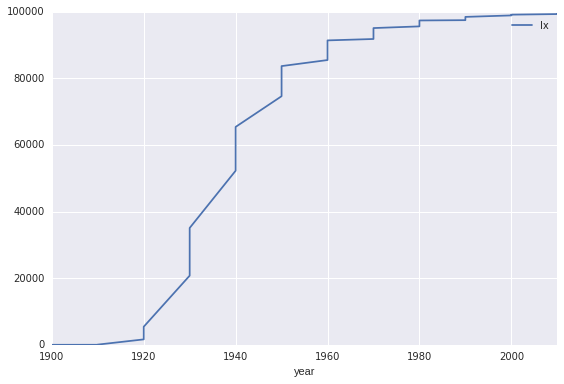

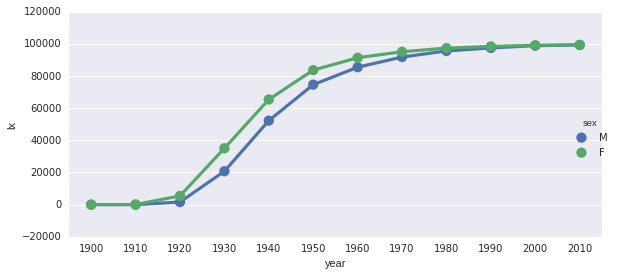

In [14]:
# Read lifetables from datasets/lifetables.csv
lifetables = pd.read_csv('datasets/lifetables.csv')

# Extract subset relevant to those alive in 2016
lifetables_2016 = lifetables[lifetables['year']+lifetables['age'] ==2016]

# Plot the mortality distribution: year vs. lx
lifetables_2016.plot(x='year',y='lx')
sns.factorplot('year', 'lx', hue = 'sex',data = lifetables_2016, aspect=2)

## 7. Smoothen the Curve!
<p>We are almost there. There is just one small glitch. The cohort life tables are provided only for every decade. In order to figure out the distribution of people alive, we need the probabilities for every year. One way to fill up the gaps in the data is to use some kind of interpolation. Let us keep things simple and use linear interpolation to fill out the gaps in values of <code>lx</code>, between the years <code>1900</code> and <code>2016</code>.</p>

In [61]:
# Create smoothened lifetable_2016_s by interpolating values of lx

year = np.arange(1900, 2016)

mf = {'M': pd.DataFrame(), 'F': pd.DataFrame()}

for sex in ['M', 'F']:
    d = lifetables_2016[lifetables_2016['sex'] == sex][['year', 'lx']]
    mf[sex] = d.set_index('year').reindex(year).interpolate().reset_index()
    mf[sex]['sex'] = sex

lifetable_2016_s = pd.concat(mf, ignore_index = True)
print(lifetable_2016_s.head(10))

   year    lx sex
0  1900   0.0   F
1  1901   6.1   F
2  1902  12.2   F
3  1903  18.3   F
4  1904  24.4   F
5  1905  30.5   F
6  1906  36.6   F
7  1907  42.7   F
8  1908  48.8   F
9  1909  54.9   F


## 8. Distribution of People Alive by Name
<p>Now that we have all the required data, we need a few helper functions to help us with our analysis. </p>
<p>The first function we will write is <code>get_data</code>,which takes <code>name</code> and <code>sex</code> as inputs and returns a data frame with the distribution of number of births and number of people alive by year.</p>
<p>The second function is <code>plot_name</code> which accepts the same arguments as <code>get_data</code>, but returns a line plot of the distribution of number of births, overlaid by an area plot of the number alive by year.</p>
<p>Using these functions, we will plot the distribution of births for boys named <strong>Joseph</strong> and girls named <strong>Brittany</strong>.</p>

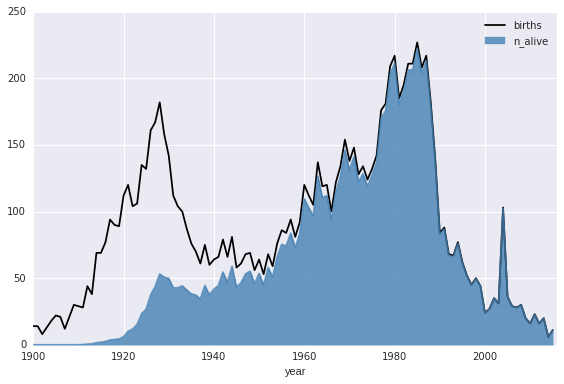

In [18]:
def get_data(name, sex):
    # YOUR CODE HERE
    name_sex = bnames[(bnames['name']==name)&(bnames['sex']==sex)]
    data = name_sex.merge(lifetable_2016_s)
    data['n_alive'] = data['births']*(data['lx']/100000)
    return data

def plot_data(name, sex):
    # YOUR CODE HERE
    fig,ax = plt.subplots()
    dat = get_data(name,sex)
    dat.plot(x='year', y='births', ax=ax, color='black')
    dat.plot(x = 'year', y = 'n_alive', 
              kind = 'area', ax = ax, 
              color = 'steelblue', alpha = 0.8)
    ax.set_xlim(1900,2016)
    
# Plot the distribution of births and number alive for Joseph and Brittany
plot_data('Joseph','F')

## 9. Estimate Age
<p>In this section, we want to figure out the probability that a person with a certain name is alive, as well as the quantiles of their age distribution. In particular, we will estimate the age of a female named <strong>Gertrude</strong>. Any guesses on how old a person with this name is? How about a male named <strong>William</strong>?</p>

In [42]:
from wquantiles import quantile

# Function to estimate age quantiles
def estimate_age(name, sex):
    # YOUR CODE HERE
    data = get_data(name, sex)
    qs = [0.75, 0.5, 0.25]
    quantiles = [2016 - int(quantile(data.year, data.n_alive, q)) 
                     for q in qs]
    result = dict(zip(['q25', 'q50', 'q75'], quantiles))
    result['p_alive'] = round(data.n_alive.sum()/data.births.sum()*100, 2)
    result['sex'] = sex
    result['name'] = name
    return pd.Series(result)

# Estimate the age of Gertrude
estimate_age('Gertrude','F')

name       Gertrude
p_alive       18.73
q25              70
q50              80
q75              89
sex               F
dtype: object

## 10. Median Age of Top 10 Female Names
<p>In the previous section, we estimated the age of a female named Gertrude. Let's go one step further this time, and compute the 25th, 50th and 75th percentiles of age, and the probability of being alive for the top 10 most common female names of all time. This should give us some interesting insights on how these names stack up in terms of median ages!</p>

In [56]:
# Create median_ages: DataFrame with Top 10 Female names, 
#    age percentiles and probability of being alive

top_10_fname = bnames[bnames.sex=='F'].groupby('name', as_index = False)\
['births'].sum().sort_values('births', ascending = False).head(10)

median_age = pd.concat([estimate_age(n,'F') for n in top_10_fname.name],
                       axis=1).T.sort_values('q50').reset_index(drop=True)

median_age 

,name,p_alive,q25,q50,q75,sex
0,Sarah,86.05,20,30,38,F
1,Elizabeth,74.49,23,38,58,F
2,Jennifer,96.35,31,38,44,F
3,Susan,85.8,52,59,65,F
4,Patricia,76.75,54,63,71,F
5,Mary,54.41,53,64,74,F
6,Linda,83.43,57,64,69,F
7,Margaret,49.47,51,64,75,F
8,Barbara,70.61,58,66,74,F
9,Dorothy,35.81,64,75,85,F
